In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.autograd import Variable
import string
from wordcloud import WordCloud
from nltk.tokenize import sent_tokenize, word_tokenize

%matplotlib inline
import matplotlib.pyplot as plt

import nltk

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
#lowercased the whole paragraph

raw_text = """We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells.""".split()

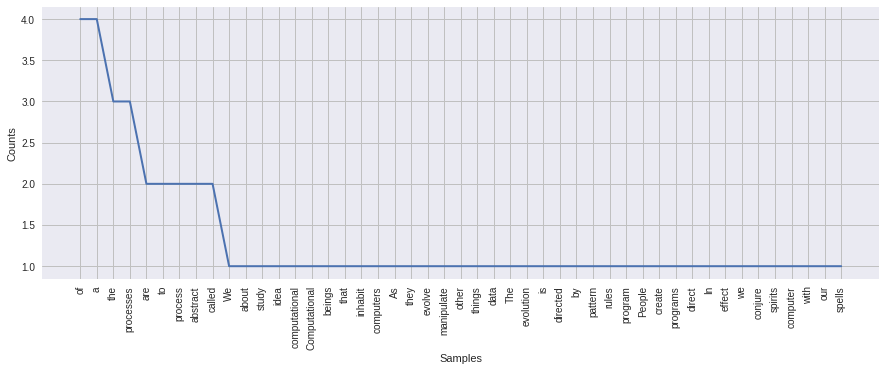

In [4]:
#removed punctuations
text = "".join([ch for ch in str(raw_text) if ch not in string.punctuation])

#getting frequency distribution
tokens_dist = nltk.word_tokenize(text)
freq_dist = nltk.FreqDist(tokens_dist)

#plotting the distribution table, visualisation purposes
plt.figure(figsize=(15, 5), facecolor='white')
freq_dist.plot()

In [5]:
#tokenise
token_text = word_tokenize(text)

print(len(token_text), token_text[:10])

62 ['We', 'are', 'about', 'to', 'study', 'the', 'idea', 'of', 'a', 'computational']


In [0]:
#vocabulary set
vocab = set(raw_text)

#vocabulary size
vocab_size = len(vocab)

In [7]:
#size chacking

vocab_size

49

In [0]:
#dictionaries mapping from word to index

word_to_ix = {word: i for i, word in enumerate(vocab)}

#and the other way round too
ix_to_word = {i: word for i, word in enumerate(vocab)}

In [9]:
data = []
for i in range(2, len(raw_text) - 2):
    context = [raw_text[i - 2], raw_text[i - 1],
               raw_text[i + 1], raw_text[i + 2]]
    target = raw_text[i]
    data.append((context, target))
print(data[:5])

[(['We', 'are', 'to', 'study'], 'about'), (['are', 'about', 'study', 'the'], 'to'), (['about', 'to', 'the', 'idea'], 'study'), (['to', 'study', 'idea', 'of'], 'the'), (['study', 'the', 'of', 'a'], 'idea')]


In [0]:
CONTEXT_SIZE = 2  # 2 words to the left, 2 to the right
EMDEDDING_DIM = 100

In [0]:
#the model

class CBOW(torch.nn.Module):

    def __init__(self, vocab_size, embedding_dim):
        super(CBOW, self).__init__()

        #emdedding_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        
        #linear layer 01
        self.linear1 = nn.Linear(embedding_dim, 128)
        
        #ReLu activation
        self.activation_function1 = nn.ReLU()
        
        #linear layer 02, vocabulary size
        self.linear2 = nn.Linear(128, vocab_size)
        
        #softmax log activation
        self.activation_function2 = nn.LogSoftmax(dim = -1)
        

    def forward(self, inputs):
        embeds = sum(self.embeddings(inputs)).view(1,-1)
        out = self.linear1(embeds)
        out = self.activation_function1(out)
        out = self.linear2(out)
        out = self.activation_function2(out)
        return out


In [0]:
#as given in the question

def make_context_vector(context, word_to_ix):
    idxs = [word_to_ix[w] for w in context]
    return torch.tensor(idxs, dtype=torch.long)

In [0]:
#creating a new model

model = CBOW(vocab_size, EMDEDDING_DIM)

In [0]:
#negative log likelihood loss

loss_function = nn.NLLLoss()
#reference used for the loss function https://pytorch.org/docs/stable/_modules/torch/nn/modules/loss.html


#SGD as optimiser and 0.001 learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [25]:
#train the model for 20 epochs

model.train()

#saving the loss after every epoch for later visualisation
loss_arr = []


for epoch in range(20):
  
    total_loss = 0
    
    for context, target in data:
      
        context_vector = make_context_vector(context, word_to_ix)  
        model.zero_grad()
        log_probs = model(context_vector)
        loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long))
        
        loss.backward()
        optimizer.step()

        total_loss += loss.data
        
        
    print("Epoch {} Loss {}".format(epoch,loss))
    loss_arr.append(loss)

Epoch 0 Loss 1.432133674621582
Epoch 1 Loss 1.345219373703003
Epoch 2 Loss 1.2641990184783936
Epoch 3 Loss 1.1877684593200684
Epoch 4 Loss 1.1148285865783691
Epoch 5 Loss 1.0468204021453857
Epoch 6 Loss 0.984316349029541
Epoch 7 Loss 0.9254283905029297
Epoch 8 Loss 0.8709700107574463
Epoch 9 Loss 0.8201642036437988
Epoch 10 Loss 0.7718801498413086
Epoch 11 Loss 0.7263011932373047
Epoch 12 Loss 0.6863970756530762
Epoch 13 Loss 0.6471600532531738
Epoch 14 Loss 0.6114463806152344
Epoch 15 Loss 0.5781760215759277
Epoch 16 Loss 0.5461506843566895
Epoch 17 Loss 0.5177440643310547
Epoch 18 Loss 0.4914712905883789
Epoch 19 Loss 0.4659290313720703


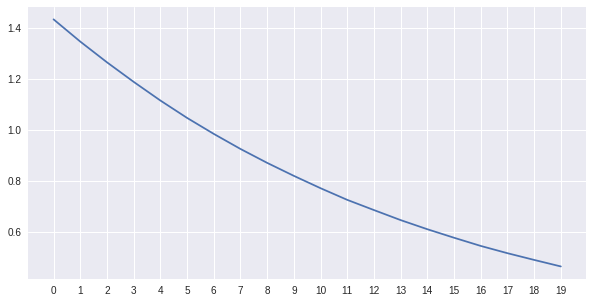

In [26]:
#plotting the loss

plt.figure(figsize=(10, 5), facecolor='white')
plt.plot(loss_arr)
plt.xticks(range(0,20))
plt.show()

In [27]:
#as given in the question, im using the same format

make_context_vector(data[0][0], word_to_ix)

tensor([24, 17, 36, 12])

In [28]:
#checking data

data[0][0]

['We', 'are', 'to', 'study']

In [0]:
#word predictor implementation

#it gets the output the our EBOW model as an input and first its finding the maximum probability result index
#and then using that index getting the word from ix_to_word list

def get_results(input, ix_to_word):
  index = 0
  
  #for and if loops for make comparisons
  for i in range(1, len(input)):
    if input[i] > input[index]:
        index = i
          
  predicted_word = ix_to_word[index]
  
  #return the actual word
  return predicted_word

In [0]:
#calling the model using the example given in the question and save it in 'a'

a = model(make_context_vector(data[0][0], word_to_ix))

In [31]:
#checking 'a' values

a[0]

tensor([-4.4199, -4.5801, -4.9768, -5.2536, -4.3664, -3.5648, -5.6927, -3.7108,
        -5.1077, -4.1375, -5.8368, -5.4729, -4.0530, -4.5276, -3.5774, -5.2609,
        -6.2456, -4.3734, -4.5356, -4.2369, -6.3128, -5.0722, -5.1041, -3.6770,
        -6.1404, -5.7320, -5.7087, -5.9491, -4.3041, -5.0567, -5.0111, -5.2694,
        -5.2454, -5.0113, -6.1844, -4.4666, -4.2035, -5.3382, -0.6768, -5.6427,
        -3.0764, -5.2361, -5.6674, -4.7802, -3.1873, -5.0163, -5.6156, -5.6343,
        -4.7430], grad_fn=<SelectBackward>)

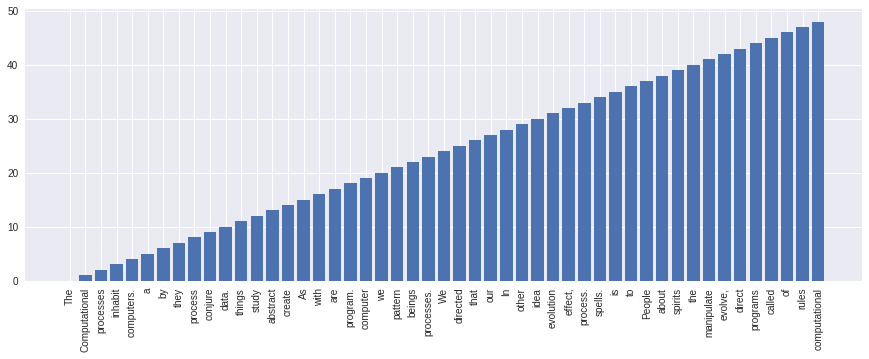

In [32]:
#ploting the word_to_ix accending order, for visualisation only

plt.figure(figsize=(15, 5), facecolor='white')
plt.bar(range(len(word_to_ix)), list(word_to_ix.values()), align='center')
plt.xticks(range(len(word_to_ix)), list(word_to_ix.keys()), rotation='vertical')
plt.show()

In [33]:
#predicting a word and print

print(data[0][0])

print('\nPredicted word: ', get_results(a[0], ix_to_word))

['We', 'are', 'to', 'study']

Predicted word:  about


In [34]:
#just another way of doing it without saving to a variable like above

print(data[5][0])

print('\nPredicted word: ', get_results(model(make_context_vector(data[5][0], word_to_ix))[0], ix_to_word))

['the', 'idea', 'a', 'computational']

Predicted word:  of
